# Лабораторна робота №3 — Кластеризація (K-Means + PCA)

## Програма
1. Завантаження датасету Spotify через `kagglehub`.
2. Огляд та підготовка даних (стандартизація числових ознак).
3. Підбір кількості кластерів методом "лікоть".
4. Кластеризація `KMeans`, зниження розмірності `PCA` та візуалізація.
5. Аналіз середніх характеристик кластерів і короткий висновок.

### Імпорти

In [ ]:
import os
from pathlib import Path

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

plt.style.use("ggplot")
SEED = 42
np.random.seed(SEED)

### Завантаження датасету з Kaggle

In [2]:
DATASET = "zaheenhamidani/ultimate-spotify-tracks-db"

download_dir = Path(kagglehub.dataset_download(DATASET))
print(f"Downloaded to: {download_dir}")

csv_candidates = sorted(download_dir.rglob("*.csv"))
if not csv_candidates:
    raise FileNotFoundError("Unluck: no .csv files found in the downloaded dataset")

DATA_PATH = csv_candidates[0]
print(f"Working with file: {DATA_PATH}")

df_raw = pd.read_csv(DATA_PATH)
df_raw.head()


Downloaded to: /home/dmutro/.cache/kagglehub/datasets/zaheenhamidani/ultimate-spotify-tracks-db/versions/3
Working with file: /home/dmutro/.cache/kagglehub/datasets/zaheenhamidani/ultimate-spotify-tracks-db/versions/3/SpotifyFeatures.csv


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


### Огляд даних
Початковий розмір таблиці та базова статистика числових колонок.

In [3]:
print(f"Initial size: {df_raw.shape}")
num_stats = df_raw.select_dtypes(include=[np.number]).describe().T
num_stats[["mean", "std", "min", "max"]]

Initial size: (232725, 18)


,mean,std,min,max
popularity,41.127502,18.189948,0.00000,100.000
acousticness,0.368560,0.354768,0.00000,0.996
danceability,0.554364,0.185608,0.05690,0.989
duration_ms,235122.339306,118935.909299,15387.00000,5552917.000
energy,0.570958,0.263456,0.00002,0.999
instrumentalness,0.148301,0.302768,0.00000,0.999
liveness,0.215009,0.198273,0.00967,1.000
loudness,-9.569885,5.998204,-52.45700,3.744
speechiness,0.120765,0.185518,0.02220,0.967
tempo,117.666585,30.898907,30.37900,242.903


### Підготовка ознак і стандартизація
Вибираємо числові аудіо-ознаки, дропаємо пропуски, масштабуємо `StandardScaler`.

In [4]:
FEATURE_CANDIDATES = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "popularity",
]
features = [c for c in FEATURE_CANDIDATES if c in df_raw.columns]

df_model = df_raw.dropna(subset=features).copy()
print(f"After dropna: {df_model.shape}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[features])
X_scaled[:3]

After dropna: (232725, 18)


array([[-0.89093479,  1.28690794,  1.29070344, -0.36796995,  0.6833763 ,
        -0.48981852,  0.66066116,  1.38074423,  1.5956073 , -1.14136792,
        -2.26100656],
       [ 0.19199369,  0.6302493 ,  0.66868254, -0.18308213, -0.34546718,
        -0.48981852, -0.32283546,  1.38843461,  1.82325339, -0.82186742,
        -2.20603102],
       [ 0.58529607, -1.66995381, -0.7184024 , -0.45583209,  1.6445698 ,
        -0.48981852, -0.56492694, -0.33421214, -0.5883258 , -0.54529771,
        -2.09607995]])

### Підмножина популярних треків для візуалізації
Для графіків залишаємо треки з `popularity ≥ 85`, але для навчання K-Means використовуємо всі.

In [5]:
POPULARITY_THRESHOLD = 85
popular_mask = df_model["popularity"] >= POPULARITY_THRESHOLD
print(f"Popular tracks for visualization: {popular_mask.sum()} of {len(df_model)}")


Popular tracks for visualization: 417 of 232725


### Підбір k методом "лікоть"
Обчислюємо інерцію для k від 2 до 15 та оцінюємо точку перегину (максимальна відстань до прямої між k_min і k_max).

Auto-picked k = 5 (check the elbow plot)


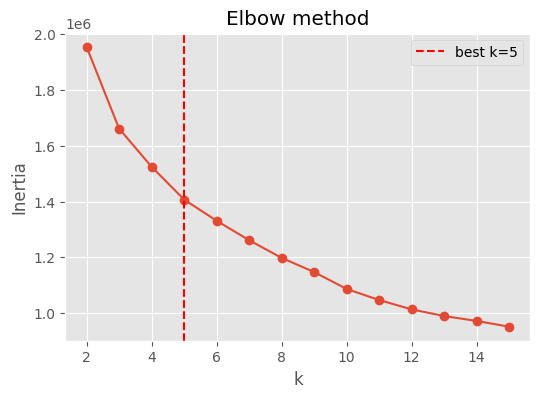

In [6]:
ks = list(range(2, 16))
inertias: list[float] = []

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=SEED)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

# Auto elbow pick: max distance from point to the line k_min..k_max (2D-safe)
points = np.column_stack((ks, inertias))
line_vec = points[-1] - points[0]
line_norm = np.linalg.norm(line_vec)

distances = []
for p in points:
    vec = p - points[0]
    area = abs(np.linalg.det(np.vstack([line_vec, vec])))
    distances.append(area / line_norm)

best_k = int(ks[int(np.argmax(distances))])
print(f"Auto-picked k = {best_k} (check the elbow plot)")

plt.figure(figsize=(6, 4))
plt.plot(ks, inertias, marker="o")
plt.axvline(best_k, color="red", linestyle="--", label=f"best k={best_k}")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow method")
plt.legend()
plt.show()


### Кластеризація K-Means
Тренуємо модель з обраним k, додаємо мітку `cluster` у DataFrame, дивимось кількість треків на кластер.

In [7]:
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=SEED)
cluster_labels = kmeans.fit_predict(X_scaled)
df_model["cluster"] = cluster_labels

cluster_counts = df_model["cluster"].value_counts().sort_index()
cluster_counts

cluster
0    45630
1    10114
2    86007
3    29876
4    61098
Name: count, dtype: int64

### PCA та візуалізація кластерів (2D)
Зменшуємо розмірність до 2 компонентів для графіка; відображаємо лише популярні треки, але кластери з урахуванням усіх.

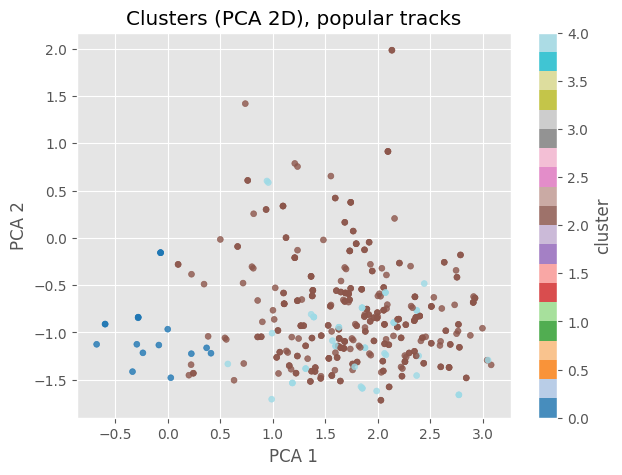

In [8]:
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)
df_model["pca1"] = X_pca[:, 0]
df_model["pca2"] = X_pca[:, 1]

df_popular = df_model[popular_mask].copy()
plt.figure(figsize=(7, 5))
scatter = plt.scatter(
    df_popular["pca1"],
    df_popular["pca2"],
    c=df_popular["cluster"],
    cmap="tab20",
    s=18,
    alpha=0.8,
)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters (PCA 2D), popular tracks")
plt.colorbar(scatter, label="cluster")
plt.show()


### Середні характеристики кластерів
Обчислюємо середні значення ознак по кожному кластеру та візуалізуємо через heatmap.

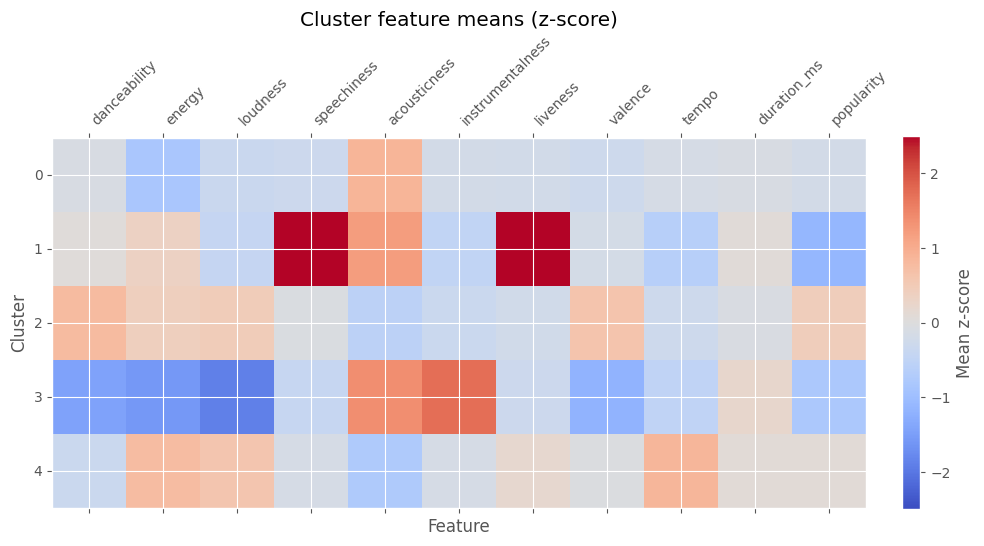

In [9]:
cluster_means = df_model.groupby("cluster")[features].mean().sort_index()
cluster_means

df_scaled = pd.DataFrame(X_scaled, columns=features)
z_means = df_scaled.groupby(df_model["cluster"]).mean().sort_index()

fig, ax = plt.subplots(figsize=(10, 5))
cax = ax.matshow(z_means, cmap="coolwarm", vmin=-2.5, vmax=2.5)
ax.set_xticks(range(len(z_means.columns)))
ax.set_xticklabels(z_means.columns, rotation=45, ha="left")
ax.set_yticks(range(len(z_means.index)))
ax.set_yticklabels(z_means.index)
ax.set_xlabel("Feature")
ax.set_ylabel("Cluster")
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04, label="Mean z-score")
plt.title("Cluster feature means (z-score)")
plt.tight_layout()
plt.show()


### Інтерпретація кластерів
Використовуємо стандартизовані середні (z-score) по ознаках, щоб побачити, які характеристики вище/нижче середніх у кожному кластері, і сформулювати опис (наприклад, "енергійні танцювальні", "акустичні спокійні" тощо).

In [10]:
df_scaled = pd.DataFrame(X_scaled, columns=features)
z_means = df_scaled.groupby(df_model['cluster']).mean()
z_means

def top_features(row, n=3):
    highs = row.sort_values(ascending=False).head(n)
    lows = row.sort_values().head(n)
    return highs, lows

for cluster_id, row in z_means.iterrows():
    highs, lows = top_features(row)
    print(f"Cluster {cluster_id}:")
    print("  Highest z-scores:")
    for feat, val in highs.items():
        print(f"    {feat}: {val:.2f}")
    print("  Lowest z-scores:")
    for feat, val in lows.items():
        print(f"    {feat}: {val:.2f}")


Cluster 0:
  Highest z-scores:
    acousticness: 0.88
    danceability: -0.10
    duration_ms: -0.11
  Lowest z-scores:
    energy: -0.83
    loudness: -0.34
    speechiness: -0.29
Cluster 1:
  Highest z-scores:
    speechiness: 4.08
    liveness: 2.60
    acousticness: 1.20
  Lowest z-scores:
    popularity: -1.12
    tempo: -0.64
    instrumentalness: -0.49
Cluster 2:
  Highest z-scores:
    danceability: 0.78
    valence: 0.61
    loudness: 0.46
  Lowest z-scores:
    acousticness: -0.55
    instrumentalness: -0.33
    tempo: -0.28
Cluster 3:
  Highest z-scores:
    instrumentalness: 1.72
    acousticness: 1.38
    duration_ms: 0.23
  Lowest z-scores:
    loudness: -1.88
    energy: -1.56
    danceability: -1.44
Cluster 4:
  Highest z-scores:
    tempo: 0.86
    energy: 0.76
    loudness: 0.60
  Lowest z-scores:
    acousticness: -0.75
    danceability: -0.32
    instrumentalness: -0.16


### Стислий опис кластерів
- Кластер 0 — спокійні, помірно акустичні, з низькою енергією та гучністю (більше "laid-back" акустики з вокалом).
- Кластер 1 — високий `speechiness`/`liveness`, помірна акустичність, низькі `tempo`/`popularity`: розмовні/реп або лайв-треки, повільні й не надто популярні.
- Кластер 2 — танцювально-мажорні: високі `danceability`, `valence`, `loudness`, низька `acousticness` → поп/електроніка для танцполу.
- Кластер 3 — акустичні інструментальні: дуже високі `instrumentalness` + `acousticness`, низькі `energy`/`loudness`/`danceability` → спокійні інструментальні композиції.
- Кластер 4 — швидкі й енергійні з високими `tempo`/`energy`/`loudness`, низька `acousticness`, трохи знижена `danceability`: гучні швидкі треки (рок/EDM).


## Висновок
Метод ліктя дозволив підібрати k для `KMeans` і сегментувати треки за аудіо-характеристиками. `PCA` допомагає візуалізувати кластери у 2D, а таблиця середніх показує, які ознаки найбільше відрізняють групи (енергійність, темп, акустичність тощо). Для глибшої інтерпретації варто проглянути топ-треки в кожному кластері або накласти додаткові метадані (жанр, виконавець).